In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 
%load_ext tensorboard

In [2]:
import tensorflow as tf 
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
import tensorflow.keras.backend as kb
import yaml
import datetime
import glob

In [3]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [4]:
from HelperFn.ExpData_Generator import TrainingGenerator
from HelperFn.ExpData_Generator import EvalTestGenerator
from HelperFn.utils import Params
from sklearn.metrics import r2_score

In [76]:
# recommended params.json is included in run_1 folder, ready for demo run. 
# archive_final_run folder contain pre-trained model (best model)
mini_EXP_name = 'new_sand_exp_wider_sedimented/architecture4/batch_size256/runs3/run3.32'
exp_folder_path = 'experiments/' + mini_EXP_name

DATA_DIR = '../processed_input_data_sand_sedimented/'
NPY_FOLDER = 'slice_npy/'
ML_EXP = 'split_master/'
Train_Master = 'train_master.txt'
Eval_Master = 'eval_master.txt'
Test_Master = 'test_master.txt'
json_path = os.path.join(exp_folder_path, 'params.json')

In [77]:
params = Params(json_path)

#input_slice_shape = (256,128,1)
input_slice_shape = (128,64,1)
batch_size = 128 #params.batch_size
MMT = 0.90 #params.bn_momentum
LR = 3e-3 #params.learning_rate
num_channels = params.num_channels
EPOCH = params.num_epochs

In [78]:
## define model
model = Sequential()
model.add(layers.Input(shape=input_slice_shape))
# channels = [num_channels, num_channels * 2,num_channels * 4 ]
channels = [num_channels, num_channels * 2]
for c in channels:
    model.add(layers.Conv2D(c, 5, padding='same'))
    model.add(layers.Conv2D(c, 5, dilation_rate = 2, padding='same'))
    model.add(layers.BatchNormalization(momentum=MMT))
    model.add(layers.Activation(activation='relu'))
    model.add(layers.MaxPooling2D(2))
model.add(layers.Flatten())
model.add(layers.Dense(channels[-1]))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization(momentum=MMT))
model.add(layers.Dense(1, activation='relu'))
#summarize the model
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 128, 64, 4)        104       
                                                                 
 conv2d_13 (Conv2D)          (None, 128, 64, 4)        404       
                                                                 
 batch_normalization_9 (Batc  (None, 128, 64, 4)       16        
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 128, 64, 4)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 32, 4)        0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 64, 32, 8)        

In [79]:
def MSE_wSD_loss(Y_true, KE_pred):
    KE_true = Y_true[:, 0]
    SD_true = Y_true[:, 1]
    mse = tf.keras.losses.MeanSquaredError()
    #for standard deviation =2 change number in front of 1e-5 to 2 and viceversa for 
    #standard deviation=1
    return mse(Y_true[:, 0], KE_pred)/((Y_true[:, 1])**1+1e-5)

def custom_accuracy_2SD(Y_true, KE_pred):
    KE_true = Y_true[:, 0]
    SD_true = Y_true[:, 1]
    KE_pred = KE_pred[:, 0]
    #also change the number in front of SD_true to 1 or 2 depending on standard deviation we are using
    C_accuracy = kb.mean(kb.cast(kb.less_equal(kb.abs(KE_pred-KE_true),1*SD_true), dtype = "float32"))
    return C_accuracy 

In [80]:
# compile the model
opt = tf.keras.optimizers.Adam(learning_rate=LR)
model.compile(optimizer=opt, loss = MSE_wSD_loss, 
              metrics=['mse', custom_accuracy_2SD])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on

In [81]:
filepath = exp_folder_path + "/weights-improvement-{epoch:02d}-{val_custom_accuracy_2SD:.2f}.hdf5"
callbacks = [
#    tf.keras.callbacks.TensorBoard(log_dir='logs'),
    tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.0001,
                                      patience=5,mode='min'),
#    tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0.000001,
#                                      patience=5,mode='max'),    
    
    tf.keras.callbacks.ModelCheckpoint(
        filepath, monitor ='val_loss', verbose=1,
        save_best_only=True, mode= 'min')
]

In [82]:
training_generator = TrainingGenerator(ML_EXP, NPY_FOLDER, Train_Master, batch_size = batch_size, data_dir=DATA_DIR)
validation_generator = EvalTestGenerator(ML_EXP, NPY_FOLDER, Eval_Master, batch_size = batch_size, data_dir=DATA_DIR)

4840
4840
 shuffling
1201
1201


In [83]:
# configure early stopping
# fit the model
history = model.fit(x=training_generator, epochs=EPOCH,
                    validation_data=validation_generator, 
                    callbacks = callbacks,
                    use_multiprocessing=False)

Epoch 1/50
37/37 [==============================] - ETA: 0s - batch: 18.0000 - size: 128.0000 - loss: 2.0557 - mse: 0.2570 - custom_accuracy_2SD: 0.2285
Epoch 00001: val_loss improved from inf to 0.74221, saving model to experiments/new_sand_exp_wider_sedimented/architecture4/batch_size256/runs3/run3.32/weights-improvement-01-0.26.hdf5
37/37 [==============================] - 16s 416ms/step - batch: 18.0000 - size: 128.0000 - loss: 2.0557 - mse: 0.2570 - custom_accuracy_2SD: 0.2285 - val_loss: 0.7422 - val_mse: 0.1004 - val_custom_accuracy_2SD: 0.2569
Epoch 2/50
37/37 [==============================] - ETA: 0s - batch: 18.0000 - size: 128.0000 - loss: 1.1187 - mse: 0.1817 - custom_accuracy_2SD: 0.3613
Epoch 00002: val_loss improved from 0.74221 to 0.45333, saving model to experiments/new_sand_exp_wider_sedimented/architecture4/batch_size256/runs3/run3.32/weights-improvement-02-0.57.hdf5
37/37 [==============================] - 16s 423ms/step - batch: 18.0000 - size: 128.0000 - loss: 1.

Epoch 14/50
37/37 [==============================] - ETA: 0s - batch: 18.0000 - size: 128.0000 - loss: 0.2503 - mse: 0.1458 - custom_accuracy_2SD: 0.6902
Epoch 00014: val_loss did not improve from 0.17296
37/37 [==============================] - 16s 421ms/step - batch: 18.0000 - size: 128.0000 - loss: 0.2503 - mse: 0.1458 - custom_accuracy_2SD: 0.6902 - val_loss: 0.1953 - val_mse: 0.1929 - val_custom_accuracy_2SD: 0.6840
Epoch 15/50
37/37 [==============================] - ETA: 0s - batch: 18.0000 - size: 128.0000 - loss: 0.2512 - mse: 0.1447 - custom_accuracy_2SD: 0.6898
Epoch 00015: val_loss did not improve from 0.17296
37/37 [==============================] - 15s 408ms/step - batch: 18.0000 - size: 128.0000 - loss: 0.2512 - mse: 0.1447 - custom_accuracy_2SD: 0.6898 - val_loss: 0.2027 - val_mse: 0.1979 - val_custom_accuracy_2SD: 0.6727
Epoch 16/50
37/37 [==============================] - ETA: 0s - batch: 18.0000 - size: 128.0000 - loss: 0.2415 - mse: 0.1474 - custom_accuracy_2SD: 0.6

Epoch 28/50
37/37 [==============================] - ETA: 0s - batch: 18.0000 - size: 128.0000 - loss: 0.1174 - mse: 0.1394 - custom_accuracy_2SD: 0.8011
Epoch 00028: val_loss improved from 0.09116 to 0.08545, saving model to experiments/new_sand_exp_wider_sedimented/architecture4/batch_size256/runs3/run3.32/weights-improvement-28-0.84.hdf5
37/37 [==============================] - 16s 431ms/step - batch: 18.0000 - size: 128.0000 - loss: 0.1174 - mse: 0.1394 - custom_accuracy_2SD: 0.8011 - val_loss: 0.0854 - val_mse: 0.1341 - val_custom_accuracy_2SD: 0.8368
Epoch 29/50
37/37 [==============================] - ETA: 0s - batch: 18.0000 - size: 128.0000 - loss: 0.1117 - mse: 0.1371 - custom_accuracy_2SD: 0.7967
Epoch 00029: val_loss did not improve from 0.08545
37/37 [==============================] - 16s 426ms/step - batch: 18.0000 - size: 128.0000 - loss: 0.1117 - mse: 0.1371 - custom_accuracy_2SD: 0.7967 - val_loss: 0.0944 - val_mse: 0.1338 - val_custom_accuracy_2SD: 0.8090
Epoch 30/50


Epoch 42/50
37/37 [==============================] - ETA: 0s - batch: 18.0000 - size: 128.0000 - loss: 0.0858 - mse: 0.1369 - custom_accuracy_2SD: 0.8328
Epoch 00042: val_loss did not improve from 0.07875
37/37 [==============================] - 15s 414ms/step - batch: 18.0000 - size: 128.0000 - loss: 0.0858 - mse: 0.1369 - custom_accuracy_2SD: 0.8328 - val_loss: 0.1252 - val_mse: 0.1036 - val_custom_accuracy_2SD: 0.6814
Epoch 43/50
37/37 [==============================] - ETA: 0s - batch: 18.0000 - size: 128.0000 - loss: 0.0862 - mse: 0.1369 - custom_accuracy_2SD: 0.8361
Epoch 00043: val_loss did not improve from 0.07875
37/37 [==============================] - 15s 411ms/step - batch: 18.0000 - size: 128.0000 - loss: 0.0862 - mse: 0.1369 - custom_accuracy_2SD: 0.8361 - val_loss: 0.5346 - val_mse: 0.3102 - val_custom_accuracy_2SD: 0.2300
Epoch 44/50
37/37 [==============================] - ETA: 0s - batch: 18.0000 - size: 128.0000 - loss: 0.0829 - mse: 0.1374 - custom_accuracy_2SD: 0.8

In [84]:
history.__dict__


{'validation_data': None,
 'model': <keras.engine.sequential.Sequential at 0x7ff1196dd690>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [2.055689321981894,
   1.1186729540696014,
   0.7287905151779587,
   0.594660810522131,
   0.6873050694530075,
   0.4852925595399496,
   0.5122139308903668,
   0.4709836067380132,
   0.3328487711983758,
   0.3262335488925109,
   0.3318695538752788,
   0.3269238431711455,
   0.28431108835581187,
   0.2502688721225068,
   0.25122745818382985,
   0.24150615809737025,
   0.2569694039789406,
   0.2097227533121367,
   0.2164126745349652,
   0.17560450329973892,
   0.1833267975095156,
   0.17737283779157176,
   0.16310418014590805,
   0.14813030732644572,
   0.14466862219410973,
   0.1372235665047491,
   0.1247827322096438,
   0.11741731416534733,
   0.11169717621964377,
   0.10561776886115203,
   0.1025772199437425,
   0.10478159805407396,
   0.10102278960717691,
   0.09495175529170681,
   0.09343398432876612,
   0.09186635

In [85]:
raw_history = history.history
with open (exp_folder_path + "/raw_history.yaml", "w") as filehandle:
    yaml.dump(history.history,filehandle)

In [86]:
with open(exp_folder_path + "/raw_history.yaml", "r") as filehandle2:
    raw_history = yaml.load(filehandle2, Loader = yaml.Loader)

In [87]:
val_loss = raw_history['val_loss']
train_accuracy = raw_history['custom_accuracy_2SD']
val_accuracy = raw_history['val_custom_accuracy_2SD']
best_model_EPOCH = val_loss.index(min(val_loss)) + 1 
selected_history = {}
selected_history['Bmodel_EPOCH'] = best_model_EPOCH
selected_history['min_val_loss'] =  np.round(min(val_loss),4)
selected_history['max_train_accuracy'] =  np.round(max(train_accuracy),4)
selected_history['max_val_accuracy'] =  np.round(max(val_accuracy),4)
selected_history['Bmodel_train_accuracy'] =  np.round(train_accuracy[val_loss.index(min(val_loss))],4)
selected_history['Bmodel_val_accuracy'] = np.round(val_accuracy[val_loss.index(min(val_loss))],4)

In [88]:
selected_history

{'Bmodel_EPOCH': 36,
 'min_val_loss': 0.0787,
 'max_train_accuracy': 0.8438,
 'max_val_accuracy': 0.8498,
 'Bmodel_train_accuracy': 0.8245,
 'Bmodel_val_accuracy': 0.8498}

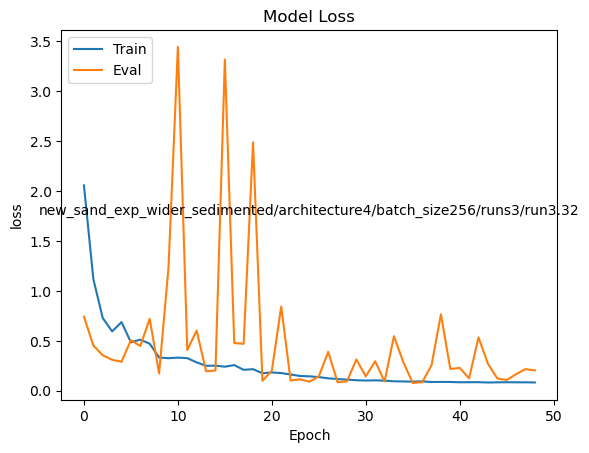

In [89]:
plt.plot(raw_history['loss'][0:EPOCH])
plt.plot(raw_history['val_loss'][0:EPOCH])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.text(0.5, 0.5, mini_EXP_name, 
         horizontalalignment = 'center', transform=plt.gca().transAxes)
plt.legend(['Train','Eval'], loc='upper left')
plt.savefig(exp_folder_path  +'/loss_.png')
plt.show()

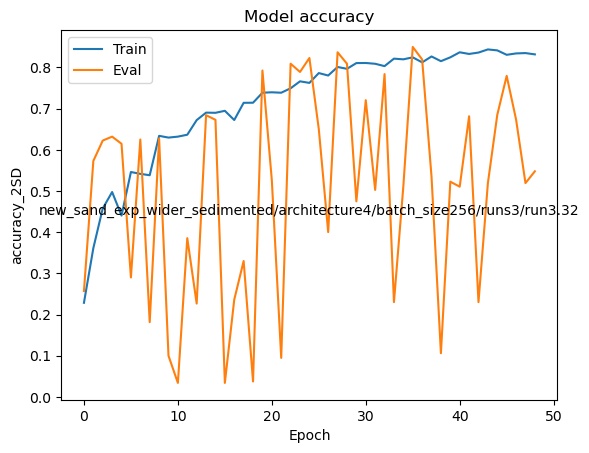

In [90]:
plt.plot(raw_history['custom_accuracy_2SD'][0:EPOCH])
plt.plot(raw_history['val_custom_accuracy_2SD'][0:EPOCH])
plt.title('Model accuracy')
plt.ylabel('accuracy_2SD')
plt.xlabel('Epoch')
plt.text(0.5, 0.5, mini_EXP_name, 
         horizontalalignment = 'center', transform=plt.gca().transAxes)
plt.legend(['Train','Eval'], loc='upper left')
plt.savefig(exp_folder_path + '/custom_accuracy_2SD.png')
plt.show()

In [91]:
files = glob.glob(exp_folder_path + '/*.hdf5',  
                   recursive = True)
saved_model = []
for file in files:
    print(file.split('/')[-1])
    saved_model.append(file.split('/')[-1])

weights-improvement-02-0.57.hdf5
weights-improvement-20-0.79.hdf5
weights-improvement-25-0.82.hdf5
weights-improvement-36-0.85.hdf5
weights-improvement-28-0.84.hdf5
weights-improvement-05-0.61.hdf5
weights-improvement-01-0.26.hdf5
weights-improvement-03-0.62.hdf5
weights-improvement-09-0.63.hdf5
weights-improvement-04-0.63.hdf5


In [92]:
# Every epoch that show improving performance will be saved. 
# weights-improvment-'Epoch'-'Eval_2SD_Accuracy'
# 'selectedE' must be updated as 'Epoch' in which 'Eval_2SD_Accuracy' is highest 

selectedE = '36'

for file in saved_model:
    if file.split('-')[-2][0:2]==str(selectedE):
        selected_weights = file
print (selected_weights)  

weights-improvement-36-0.85.hdf5


In [93]:
filepath = exp_folder_path + '/' + selected_weights 
print(filepath)

experiments/new_sand_exp_wider_sedimented/architecture4/batch_size256/runs3/run3.32/weights-improvement-36-0.85.hdf5


In [94]:
best_model = tf.keras.models.load_model(
    filepath, custom_objects = {"MSE_wSD_loss":MSE_wSD_loss, 
                                "custom_accuracy_2SD": custom_accuracy_2SD})
# best_model = tf.keras.models.load_model(filepath)
# best_model = tf.keras.models.load_model(filepath, custom_objects={"MSE_wSD_loss":MSE_wSD_loss})
# best_model = tf.keras.models.load_model(filepath)

In [95]:
#apply best model to three subset of data

##Training
train_generator = EvalTestGenerator(ML_EXP, NPY_FOLDER, Train_Master, 
                                       batch_size = batch_size, 
                                       data_dir=DATA_DIR, shuffle = False)
train_label = np.hstack([batch[1][:,0] for batch in train_generator])
train_SD = np.hstack([batch[1][:,1] for batch in train_generator])
train_pred = best_model.predict(x=train_generator)

##Validation
eval_generator = EvalTestGenerator(ML_EXP, NPY_FOLDER, Eval_Master, 
                                         batch_size = batch_size, 
                                         data_dir=DATA_DIR, shuffle = False)
eval_label = np.hstack([batch[1][:,0] for batch in eval_generator])
eval_SD = np.hstack([batch[1][:,1] for batch in eval_generator])
eval_pred = best_model.predict(x=eval_generator)

##Testing
test_generator = EvalTestGenerator(ML_EXP, NPY_FOLDER, Test_Master, 
                                   batch_size = batch_size, 
                                   data_dir=DATA_DIR, shuffle = False)
test_label = np.hstack([batch[1][:,0] for batch in test_generator])
test_SD = np.hstack([batch[1][:,1] for batch in test_generator])
test_pred = best_model.predict(x=test_generator)

4840
4840
1201
1201
701
701


In [96]:
train_LSP = [train_label,train_SD,train_pred]
eval_LSP = [eval_label,eval_SD,eval_pred]
test_LSP = [test_label,test_SD,test_pred]
generator_LSP = [train_LSP,eval_LSP,test_LSP]

In [97]:
def plotting_with_TS_V(generator_LSP, mode, selected_EP):
    ## make cross plot between prediction and label with highlighted color for subset that meet threashold
    
    fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(5,12.5))

    for g, m, ax in zip(generator_LSP, mode, axs): 
        label = g[0]
        SD = g[1]
        pred = g[2].flatten()
#         if len(pred) == len(label):
#             print(len(pred))
        idx = np.abs(pred-label) > 1*SD
        error_pct = np.round(100*np.sum(idx)/len(pred), 1)
        

        ax.plot(pred, label,'b.',alpha=0.1, label=f'Correct ' + str(100 - error_pct)+ '%')
        ax.plot(pred[idx], label[idx], 'r.', alpha=0.1, label=f'Incorrect '+ str(error_pct)+ '%')
        plt.xticks(fontsize = 12)
        plt.yticks(fontsize = 12)
        ax.plot([0, 1], [0, 1], 'k', alpha=0.5)
        ax.set_title(str(m), fontsize = 24, loc = 'center')

        #text_error = '% error (>2SD) = ' +str(error_pct) + '%'
        #ax.text(0.7, 0.1, text_error, fontsize = 12,
                #horizontalalignment = 'center', transform=ax.transAxes)
        ax.legend(loc='upper left')
        ax.set_ylabel('Experimental Value', fontsize =18)
    axs[2].set_xlabel('CNN Prediction', fontsize = 18)
    #plt.xlim([0.0, 1.0])
    #plt.ylim([0.0, 1.0])
    
    plt.tight_layout()
    plt.show
    plt.savefig(exp_folder_path  +'/train_results_.svg', dpi=900)
    plt.savefig(exp_folder_path  +'/train_results_.jpeg', dpi=900)

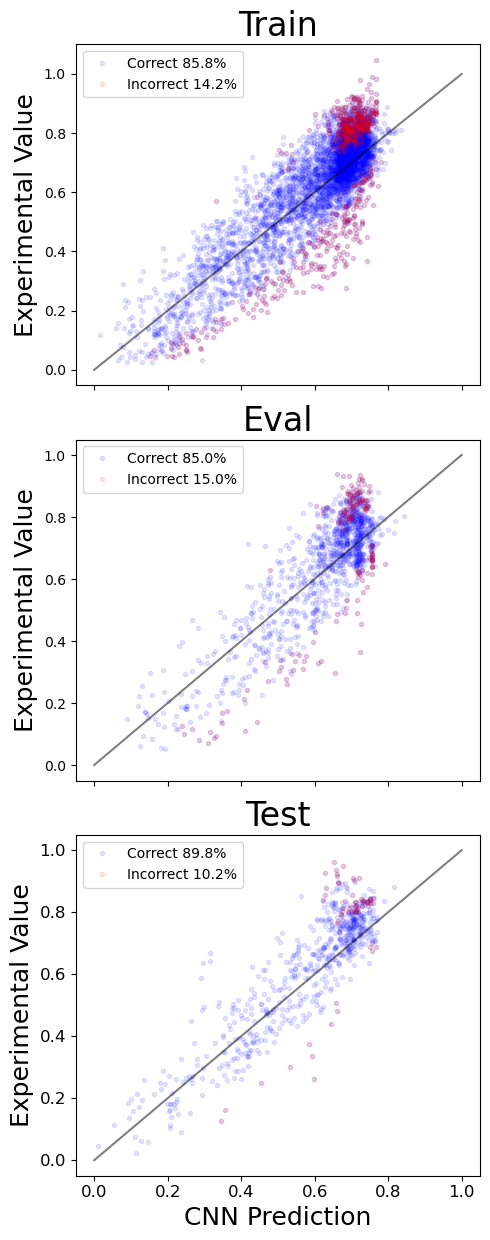

In [98]:
plotting_with_TS_V(generator_LSP, ['Train', 'Eval', 'Test'], selected_EP = selectedE)